# Importing all the dependency

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!pip install transformers[sentencepiece] -q 

In [ ]:
!pip install transformers datasets evaluate

In [ ]:
!pip install tensorflow-text

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re
import torch
import os
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, logging
from datasets import Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tf-models-official

In [ ]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
import tensorflow_text as text  
from keras.utils import to_categorical
from official.nlp import optimization  
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from keras.utils import to_categorical

In [ ]:
import tensorflow_hub as hub

Loading the train and test data set

In [ ]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")

In [ ]:
print(df_train)
print(df_test)

In [ ]:
df_train.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
df_train['Text']= df_train['Title']+ ' ' + df_train['Description']

In [ ]:
df_test['Text']= df_test['Title']+ ' ' + df_test['Description']

In [ ]:
df_train.head()

,Class Index,Title,Description,Text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."


In [ ]:
df_train = df_train.drop(['Title', 'Description'], axis=1)
df_test = df_test.drop(['Title', 'Description'], axis=1)

In [ ]:
df_train.head()

,Class Index,Text
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


In [ ]:
df_train = df_train.rename(columns={'Class Index': 'Label'})

In [ ]:
df_test = df_test.rename(columns={'Class Index': 'Label'})

In [ ]:
TEXT_LABELS = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}

In [ ]:
print('Shape of the training data: ', df_train.shape)
print('Shape of the test data: ', df_test.shape)

Shape of the training data:  (120000, 2)
Shape of the test data:  (7600, 2)


The train set had 120000 text i.e, 30000 text in each label

In [ ]:
df_train.groupby('Label').count()

,Text
Label,
1,30000
2,30000
3,30000
4,30000


In [ ]:
max_rows_per_label_train = 2000
train = df_train.groupby('Label').apply(lambda x: x.sample(min(len(x), max_rows_per_label_train)))


In [ ]:
max_rows_per_label_test = 500
test = df_test.groupby('Label').apply(lambda x: x.sample(min(len(x), max_rows_per_label_test)))

In [ ]:
train.head()

Label                                               Text
Label                                                                
1     1866       1  Ill. Plans Online Network to Import Drugs CHIC...
      69293      1  Bush Signs  #36;136B Corporate Tax Cut Bill (A...
      97034      1  Slumping Dollar to Dominate G-20 Meeting (AP) ...
      56568      1  War crimes suspect surrenders to Serbs One of ...
      41289      1  Palestinian Gunmen Kidnap CNN Producer (AP) AP...

In [ ]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

From 30000 text im keeping 2000 text for each label to easy my training process

In [ ]:
train.groupby('Label').count()

,Text
Label,
1,2000
2,2000
3,2000
4,2000


Also there are 500 text each for testing

In [ ]:
test.groupby('Label').count()

,Text
Label,
1,500
2,500
3,500
4,500


In [ ]:
train.head()

,Label,Text
0,1,Ill. Plans Online Network to Import Drugs CHIC...
1,1,Bush Signs #36;136B Corporate Tax Cut Bill (A...
2,1,Slumping Dollar to Dominate G-20 Meeting (AP) ...
3,1,War crimes suspect surrenders to Serbs One of ...
4,1,Palestinian Gunmen Kidnap CNN Producer (AP) AP...


# Pre-Processing 

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word.lower() not in stopwords.words('english')]
    return " ".join(words)

In [ ]:
train['Category'] = train['Label'].map(TEXT_LABELS)

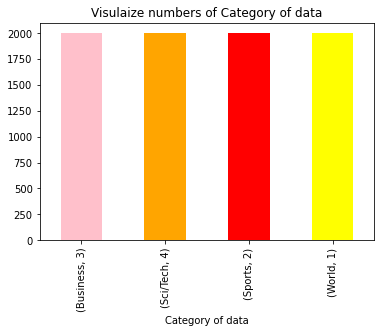

In [ ]:
train.groupby('Category').Label.value_counts().plot(kind = "bar", color = ["pink", "orange", "red", "yellow", "blue"])
plt.xlabel("Category of data")
plt.title("Visulaize numbers of Category of data")
plt.show()

In [ ]:
train['clean_text'] = train['Text'].apply(remove_stopwords)

In [ ]:
test['clean_text']=test['Text'].apply(remove_stopwords)

In [ ]:
def special_char(text):
  reviews = ''
  for x in text:
    if x.isalnum():
      reviews = reviews + x
    else:
      reviews = reviews + ' '
  return reviews

In [ ]:
test.head()

,Label,Text,clean_text
0,1,Explosion in Kathmandu injures 30 At least 30 ...,Explosion Kathmandu injures 30 least 30 people...
1,1,China Says Taiwan Spy Also Operated in U.S. - ...,China Says Taiwan Spy Also Operated U.S. - Med...
2,1,U.S. Forces Push Into Heart of Fallujah U.S. A...,U.S. Forces Push Heart Fallujah U.S. Army Mari...
3,1,Pinochet is ordered to stand trial for murder ...,Pinochet ordered stand trial murder Augusto Pi...
4,1,Iran Says EU Nuke Negotiations in Final Stages...,Iran Says EU Nuke Negotiations Final Stages TE...


In [ ]:
test['clean_text']=test['clean_text'].apply(special_char)

In [ ]:
def convert_lower(text):
   return text.lower()

In [ ]:
test['clean_text']=test['clean_text'].apply(convert_lower)

In [ ]:
test.head()

,Label,Text,clean_text
0,1,Explosion in Kathmandu injures 30 At least 30 ...,explosion kathmandu injures 30 least 30 people...
1,1,China Says Taiwan Spy Also Operated in U.S. - ...,china says taiwan spy also operated u s med...
2,1,U.S. Forces Push Into Heart of Fallujah U.S. A...,u s forces push heart fallujah u s army mari...
3,1,Pinochet is ordered to stand trial for murder ...,pinochet ordered stand trial murder augusto pi...
4,1,Iran Says EU Nuke Negotiations in Final Stages...,iran says eu nuke negotiations final stages te...


In [ ]:
train['clean_text']=train['clean_text'].apply(special_char)

In [ ]:
train['clean_text']=train['clean_text'].apply(convert_lower)

In [ ]:
train['clean_text'][1]

'bush signs  36 136b corporate tax cut bill  ap  ap   president bush showered  36 136 billion new tax breaks businesses  farmers groups friday  quietly signing sweeping rewrite corporate tax law nearly two decades '

In [ ]:
train.sample()

,Label,Text,Category,clean_text
3483,2,Vermeil's Friends Back Troubled Coach (AP) AP ...,Sports,vermeil s friends back troubled coach ap ap ...


In [ ]:
le = LabelEncoder()

X_train = train['clean_text']
y_train = train['Label']
y_train = le.fit_transform(y_train)
y_train = to_categorical(y_train, num_classes=4)


X_test = test['clean_text']
y_test = test['Label']
y_test = le.transform(y_test)
y_test = to_categorical(y_test, num_classes=4)

In [ ]:
print(X_test.shape)

(2000,)


In [ ]:
print(y_test.shape)

(2000, 4)


In [ ]:
train.shape[0]

8000

# Loading the PreTrained BERT Model

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      
sequence_output = outputs["sequence_output"] 

In [ ]:
# Verify that the preprocessor works:
hub_inputs = preprocessor(['ID for each word, with zero padding at the end.'])
{key: value[0, :25].numpy() for key, value in hub_inputs.items()}

{'input_word_ids': array([  101,  8909,  2005,  2169,  2773,  1010,  2007,  5717, 11687,
         4667,  2012,  1996,  2203,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], dtype=int32),
 'input_mask': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0], dtype=int32),
 'input_type_ids': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0], dtype=int32)}

In [ ]:
result = encoder(
    inputs=hub_inputs,
    training=False,
)

print("Pooled output shape:", result['pooled_output'].shape)
print("Sequence output shape:", result['sequence_output'].shape)

Pooled output shape: (1, 768)
Sequence output shape: (1, 128, 768)


# Building the Model

In [ ]:
epochs = 4
batch_size = 32
eval_batch_size = 32

train_data_size = train.shape[0]
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
def build_model(num_classes, optimizer, max_len=512):
    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(64, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    out = tf.keras.layers.Dense(num_classes, activation='softmax', name='classifier')(net)
    
    
    model = tf.keras.models.Model(text_input, out)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
model = build_model(num_classes=4, optimizer=optimizer)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

history = model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test, y_test),
          epochs=epochs, 
          callbacks=[checkpoint, early_stopping], 
          batch_size=batch_size,
          validation_batch_size=eval_batch_size,
          verbose=1)

Epoch 1/4
250/250 [==============================] - ETA: 0s - loss: 0.6020 - accuracy: 0.7692
Epoch 1: val_accuracy improved from -inf to 0.89900, saving model to model.h5
250/250 [==============================] - 283s 1s/step - loss: 0.6020 - accuracy: 0.7692 - val_loss: 0.3012 - val_accuracy: 0.8990
Epoch 2/4
250/250 [==============================] - ETA: 0s - loss: 0.2531 - accuracy: 0.9250
Epoch 2: val_accuracy improved from 0.89900 to 0.90800, saving model to model.h5
250/250 [==============================] - 245s 979ms/step - loss: 0.2531 - accuracy: 0.9250 - val_loss: 0.3125 - val_accuracy: 0.9080
Epoch 3/4
250/250 [==============================] - ETA: 0s - loss: 0.1587 - accuracy: 0.9525
Epoch 3: val_accuracy improved from 0.90800 to 0.91100, saving model to model.h5
250/250 [==============================] - 267s 1s/step - loss: 0.1587 - accuracy: 0.9525 - val_loss: 0.3099 - val_accuracy: 0.9110
Epoch 4/4
250/250 [==============================] - ETA: 0s - loss: 0.0986 

In [ ]:
y_proba = model.predict(X_test, batch_size=eval_batch_size)

63/63 [==============================] - 22s 324ms/step


In [ ]:
print(len(y_proba))
print(y_proba)

2000
[[9.9830413e-01 7.3008134e-04 5.7248806e-04 3.9331295e-04]
 [9.9821377e-01 1.9664383e-04 3.6859891e-04 1.2209894e-03]
 [9.9894828e-01 5.0677120e-04 2.4769420e-04 2.9717438e-04]
 ...
 [1.0974297e-03 1.0738651e-03 6.2671485e-03 9.9156159e-01]
 [8.9066807e-04 2.6047099e-04 9.7034520e-01 2.8503614e-02]
 [1.1566615e-03 1.5600650e-03 8.4259018e-04 9.9644071e-01]]


In [ ]:
y_pred = np.argmax(y_proba, axis=1)

In [ ]:
print(len(y_pred))
print(y_pred)

2000
[0 0 0 ... 3 2 3]


In [ ]:
y_pred_labels = [TEXT_LABELS[x] for x in le.inverse_transform(y_pred)]
y_true_labels = [TEXT_LABELS[x] for x in test['Label']]

In [ ]:
len(y_true_labels)

2000

# Accuracy Check

In [ ]:
print(classification_report(y_true=y_true_labels, y_pred=y_pred_labels))
print(confusion_matrix(y_true_labels, y_pred_labels))

              precision    recall  f1-score   support

    Business       0.89      0.88      0.88       500
    Sci/Tech       0.88      0.89      0.88       500
      Sports       0.94      0.98      0.96       500
       World       0.94      0.89      0.91       500

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000

[[438  39   6  17]
 [ 39 446   6   9]
 [  2   2 492   4]
 [ 15  22  17 446]]


In [ ]:
print(y_true_labels)

['Business', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'World', 'World', 'World', 'World', 'World', 'World', 'World', 'World', 'Sports', 'Business', 'World', 'Sci/Tech', 'Sports', 'Sports', 'World', 'Sci/Tech', 'World', 'Sports', 'World', 'Sports', 'World', 'Sci/Tech', 'Business', 'Sci/Tech', 'World', 'World', 'Business', 'Business', 'Sports', 'Sports', 'Sports', 'Sci/Tech', 'World', 'Sci/Tech', 'World', 'World', 'Sports', 'World', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'World', 'Sci/Tech', 'Sports', 'World', 'Sports', 'World', 'World', 'World', 'Sports', 'Business', 'Business', 'World', 'World', 'Business', 'World', 'World', 'Sci/Tech', 'World', 'Business', 'Sci/Tech', 'Busin

# Check input Manually

In [ ]:
text = ["Reuters - A car bomb exploded near a U.S.\military patrol in the town of Baiji, north of Baghdad, on\Tuesday, killing at least seven Iraqis and wounding 20 people,\including two U.S. soldiers, doctors and the military said."]

In [ ]:
y_proba = model.predict(text)
y_pred = np.argmax(y_proba, axis=1)
y_pred_labels = [TEXT_LABELS[x] for x in le.inverse_transform(y_pred)]
print("\n\n",y_pred_labels[0])

1/1 [==============================] - 0s 70ms/step


 World
